<a href="https://colab.research.google.com/github/MuhametshaKakayev/PneumaniaInceptionV3/blob/main/Guncel_%22Phenmon%C4%B1aXray%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!rm -rf /content/*

In [ ]:
# 1. Kaggle API’yı kur
!pip install --quiet kaggle

# 2. Kaggle JSON dosyanı doğru yere kopyala
import os
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)
os.replace('/content/kaggle(1).json', os.path.expanduser('~/.kaggle/kaggle.json'))
os.chmod(os.path.expanduser('~/.kaggle/kaggle.json'), 0o600)

# 3. Veri setini indir ve aç
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content --unzip

# 4. Ana klasör yolunu belirt ve yapıyı göster
base_dir = '/content/chest_xray'
print("Klasör yapısı:")
!find $base_dir -maxdepth 2 -type d

# 5. TÜM veri setini (örneklemeden) yeni klasöre kopyala
import shutil

full_dir = '/content/chest_xray_full'

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(base_dir, split, cls)
        dst = os.path.join(full_dir, split, cls)
        os.makedirs(dst, exist_ok=True)

        files = os.listdir(src)
        for f in files:
            shutil.copy(os.path.join(src, f), os.path.join(dst, f))

print("Tüm veri seti başarıyla kopyalandı:", full_dir)


# 6. Küçük klasörü zip’le ve bilgisayarına indir
#import shutil
#from google.colab import files

#zip_path = '/content/chest_xray_small.zip'
#shutil.make_archive('/content/chest_xray_small', 'zip', small_dir)
#files.download(zip_path)


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:16<00:00, 280MB/s]
100% 2.29G/2.29G [00:16<00:00, 153MB/s]
Klasör yapısı:
/content/chest_xray
/content/chest_xray/val
/content/chest_xray/val/PNEUMONIA
/content/chest_xray/val/NORMAL
/content/chest_xray/test
/content/chest_xray/test/PNEUMONIA
/content/chest_xray/test/NORMAL
/content/chest_xray/chest_xray
/content/chest_xray/chest_xray/val
/content/chest_xray/chest_xray/test
/content/chest_xray/chest_xray/train
/content/chest_xray/__MACOSX
/content/chest_xray/__MACOSX/chest_xray
/content/chest_xray/train
/content/chest_xray/train/PNEUMONIA
/content/chest_xray/train/NORMAL
Tüm veri seti başarıyla kopyalandı: /content/chest_xray_full


In [ ]:
import os
import math
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import random
import shutil

full_dir = '/content/chest_xray_full'  # Orijinal tüm veri seti klasörü
balanced_dir = '/content/chest_xray_balanced'

val_split_ratio = 0.15  # %15 validation ayır

# Klasörleri hazırla
for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        os.makedirs(os.path.join(balanced_dir, split, cls), exist_ok=True)

# Test ve orijinal val klasörünü olduğu gibi kopyala
for split in ['val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        src = os.path.join(full_dir, split, cls)
        dst = os.path.join(balanced_dir, split, cls)
        for f in os.listdir(src):
            shutil.copy2(os.path.join(src, f), os.path.join(dst, f))

# Train içinden validation ayır ve train setini dengele
normal_train_files = []
pneumonia_train_files = []

for cls in ['NORMAL', 'PNEUMONIA']:
    src_train = os.path.join(full_dir, 'train', cls)
    files = os.listdir(src_train)
    random.shuffle(files)

    val_count = int(len(files) * val_split_ratio)
    val_files = files[:val_count]
    train_files = files[val_count:]

    # Validation dosyalarını kopyala
    for f in val_files:
        shutil.copy2(os.path.join(src_train, f), os.path.join(balanced_dir, 'val', cls, f))

    # Train dosyalarını listele (daha sonra dengeleme için)
    if cls == 'NORMAL':
        normal_train_files = train_files
    else:
        pneumonia_train_files = train_files

# Validation setini dengele
normal_val_path = os.path.join(balanced_dir, 'val', 'NORMAL')
pneumonia_val_path = os.path.join(balanced_dir, 'val', 'PNEUMONIA')

normal_val_files = os.listdir(normal_val_path)
pneumonia_val_files = os.listdir(pneumonia_val_path)

# PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_val_sample = random.sample(pneumonia_val_files, min(len(pneumonia_val_files), len(normal_val_files)))

# Fazla validation dosyalarını sil
for f in pneumonia_val_files:
    if f not in pneumonia_val_sample:
        os.remove(os.path.join(pneumonia_val_path, f))

print("Validation seti dengelendi.")

# Train setini dengele: PNEUMONIA sayısını NORMAL sayısına indir
pneumonia_train_sample = random.sample(pneumonia_train_files, min(len(pneumonia_train_files), len(normal_train_files)))

# Train dosyalarını kopyala
for f in normal_train_files:
    shutil.copy2(os.path.join(full_dir, 'train', 'NORMAL', f), os.path.join(balanced_dir, 'train', 'NORMAL', f))

for f in pneumonia_train_sample:
    shutil.copy2(os.path.join(full_dir, 'train', 'PNEUMONIA', f), os.path.join(balanced_dir, 'train', 'PNEUMONIA', f))

print("Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı:", balanced_dir)

# Klasör içeriğini say ve yazdır
splits = ['train', 'val', 'test']
classes = ['NORMAL', 'PNEUMONIA']

for split in splits:
    print(f"\n--- {split.upper()} ---")
    for cls in classes:
        path = os.path.join(balanced_dir, split, cls)
        if os.path.exists(path):
            count = len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
            print(f"{cls}: {count} görüntü")
        else:
            print(f"{cls}: klasör bulunamadı")


Validation seti dengelendi.
Train seti dengelendi, validation ayrıldı ve yeni klasöre kopyalandı: /content/chest_xray_balanced

--- TRAIN ---
NORMAL: 1140 görüntü
PNEUMONIA: 1140 görüntü

--- VAL ---
NORMAL: 209 görüntü
PNEUMONIA: 209 görüntü

--- TEST ---
NORMAL: 234 görüntü
PNEUMONIA: 390 görüntü


Found 2280 images belonging to 2 classes.
Found 418 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_470 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_470[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_470      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_471 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_470[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_471[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_471      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_472 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_471[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_472[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_472      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 73, 73,    │          0 │ activation_472[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_473 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_20… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_473[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_473      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_474 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_473[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_474[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_474      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 22,065,185 (84.17 MB)

 Trainable params: 7,435,713 (28.36 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

Trainable parameters: 7435713
Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6238 - loss: 0.6432

100/100 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.6247 - loss: 0.6425 - val_accuracy: 0.6562 - val_loss: 0.5618 - learning_rate: 1.0000e-05
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7817 - loss: 0.4700

100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.7821 - loss: 0.4695 - val_accuracy: 0.6875 - val_loss: 0.4918 - learning_rate: 1.0000e-05
Epoch 3/20
 85/100 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - accuracy: 0.8579 - loss: 0.3671

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.8561 - loss: 0.3691 - val_accuracy: 0.7500 - val_loss: 0.4894 - learning_rate: 1.0000e-05
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8515 - loss: 0.3214

100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.8516 - loss: 0.3214 - val_accuracy: 0.7750 - val_loss: 0.4770 - learning_rate: 1.0000e-05
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8826 - loss: 0.3085

100/100 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.8827 - loss: 0.3084 - val_accuracy: 0.8562 - val_loss: 0.3419 - learning_rate: 1.0000e-05
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.8686 - loss: 0.2875 - val_accuracy: 0.8500 - val_loss: 0.3238 - learning_rate: 1.0000e-05
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9048 - loss: 0.2604

100/100 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.9048 - loss: 0.2604 - val_accuracy: 0.8938 - val_loss: 0.2736 - learning_rate: 1.0000e-05
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9007 - loss: 0.2696

100/100 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.9007 - loss: 0.2695 - val_accuracy: 0.9250 - val_loss: 0.2395 - learning_rate: 1.0000e-05
Epoch 9/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 260s 3s/step - accuracy: 0.8774 - loss: 0.2684 - val_accuracy: 0.9125 - val_loss: 0.2627 - learning_rate: 1.0000e-05
Epoch 10/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8917 - loss: 0.2701
Epoch 10: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 290s 3s/step - accuracy: 0.8919 - loss: 0.2698 - val_accuracy: 0.9000 - val_loss: 0.2665 - learning_rate: 1.0000e-05
Epoch 11/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9132 - loss: 0.2167

100/100 ━━━━━━━━━━━━━━━━━━━━ 323s 3s/step - accuracy: 0.9133 - loss: 0.2166 - val_accuracy: 0.9375 - val_loss: 0.1582 - learning_rate: 3.0000e-06
Epoch 12/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9091 - loss: 0.2312 - val_accuracy: 0.9125 - val_loss: 0.1923 - learning_rate: 3.0000e-06
Epoch 13/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9180 - loss: 0.2219
Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-06.
100/100 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9180 - loss: 0.2219 - val_accuracy: 0.9187 - val_loss: 0.2160 - learning_rate: 3.0000e-06
Epoch 14/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 321s 3s/step - accuracy: 0.9330 - loss: 0.2066 - val_accuracy: 0.9187 - val_loss: 0.2171 - learning_rate: 1.0000e-06
Epoch 15/20
 85/100 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.9256 - loss: 0.2154

100/100 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9241 - loss: 0.2149 - val_accuracy: 0.9438 - val_loss: 0.1586 - learning_rate: 1.0000e-06
Epoch 16/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 289s 3s/step - accuracy: 0.9019 - loss: 0.2496 - val_accuracy: 0.9438 - val_loss: 0.1722 - learning_rate: 1.0000e-06
Epoch 17/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 288s 3s/step - accuracy: 0.9276 - loss: 0.1754 - val_accuracy: 0.9438 - val_loss: 0.2122 - learning_rate: 1.0000e-06
Epoch 18/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.9204 - loss: 0.2375 - val_accuracy: 0.9125 - val_loss: 0.2448 - learning_rate: 1.0000e-06
Epoch 19/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 310s 3s/step - accuracy: 0.9158 - loss: 0.2010 - val_accuracy: 0.9125 - val_loss: 0.2122 - learning_rate: 1.0000e-06
Epoch 20/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.9199 - loss: 0.2293 - val_accuracy: 0.9187 - val_loss: 0.2109 - learning_rate: 1.0000e-06
78/78 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step

Confusion Matrix:
 [[20

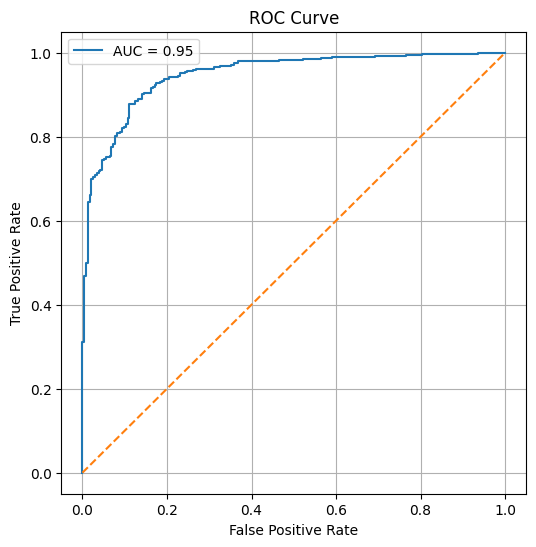

In [ ]:
 #1. Gerekli Kütüphaneler
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 2. Veri Yükleme ve Önişleme
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_it = train_gen.flow_from_directory(
    '/content/chest_xray_balanced/train',
    target_size=(299, 299),
    batch_size=8,
    class_mode='binary'
)

val_it = val_gen.flow_from_directory(
    '/content/chest_xray_balanced/val',
    target_size=(299, 299),
    batch_size=8,
    class_mode='binary'
)

test_it = test_gen.flow_from_directory(
    '/content/chest_xray_balanced/test',
    target_size=(299, 299),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

# 3. Model Oluşturma
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True


model.compile(optimizer=Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Model özetini yazdır
model.summary()

# Trainable parametre sayısı
trainable_count = np.sum([np.prod(v.shape) for v in model.trainable_weights])
print(f"Trainable parameters: {trainable_count}")


# 4. Callbacks
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6, verbose=1)

# 5. Eğitim
history = model.fit(
    train_it,
    epochs=20,
    steps_per_epoch=100,
    validation_data=val_it,
    validation_steps=20,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

# 6. Test ve Değerlendirme
y_true = test_it.classes
y_prob = model.predict(test_it).ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred = (y_prob > optimal_threshold).astype(int)

cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

accuracy  = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if tp+fp else 0
recall    = tp / (tp + fn) if tp+fn else 0
specificity = tn / (tn + fp) if tn+fp else 0
f1 = 2 * (precision * recall) / (precision + recall) if precision+recall else 0

print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=['NORMAL','PNEUMONIA']))
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision:   {precision:.4f}")
print(f"Recall:      {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1 Score:    {f1:.4f}")

# 7. ROC
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()

Seçilen test görüntüsü: /content/chest_xray_balanced/test/PNEUMONIA/person101_bacteria_485.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Tahmin: PNEUMONIA (%97.73 kesinlik)
Gerçek sınıf: PNEUMONIA


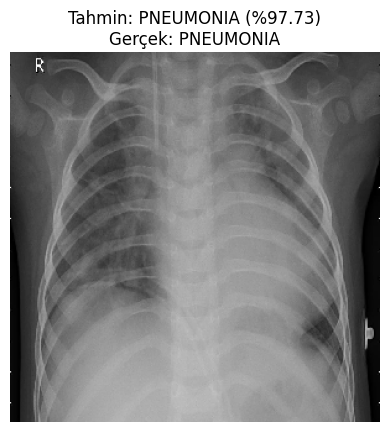

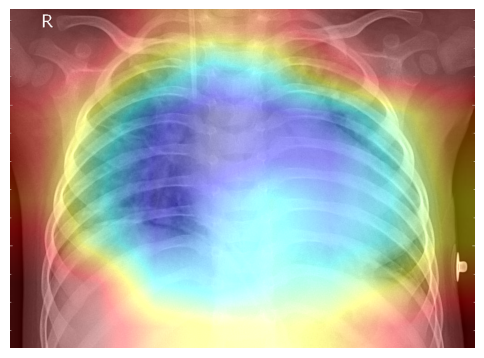

In [45]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Test klasörleri
test_pneumonia_dir = '/content/chest_xray_balanced/test/PNEUMONIA'
test_normal_dir = '/content/chest_xray_balanced/test/NORMAL'

# Tüm test görüntülerini topla
all_test_files = []
for cls_dir in [test_pneumonia_dir, test_normal_dir]:
    files = [os.path.join(cls_dir, f) for f in os.listdir(cls_dir) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
    all_test_files.extend(files)

# Rastgele bir test görüntüsü seç
img_path = random.choice(all_test_files)
print(f"Seçilen test görüntüsü: {img_path}")

# Görüntüyü yükle ve ön işle
img = image.load_img(img_path, target_size=(299, 299))
img_array = image.img_to_array(img)
img_array_for_display = img_array.astype('uint8')  # Görüntü gösterim için (0-255 aralığında)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Tahmin yap
preds = model.predict(img_array)
prob = preds[0][0]
label = "PNEUMONIA" if prob > 0.5 else "NORMAL"
confidence = prob if prob > 0.5 else 1 - prob
print(f"Tahmin: {label} (%{confidence*100:.2f} kesinlik)")

# Gerçek sınıfı yol isminden çıkar (örnek: "PNEUMONIA" içeriyor mu?)
actual_class = "PNEUMONIA" if "PNEUMONIA" in img_path else "NORMAL"
print(f"Gerçek sınıf: {actual_class}")

# Tahmin sonucunu göster
plt.imshow(img_array_for_display)
plt.axis('off')
plt.title(f"Tahmin: {label} (%{confidence*100:.2f})\nGerçek: {actual_class}")
plt.show()

# Grad-CAM ısı haritasını oluştur
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Görüntü üzerine ısı haritasını yerleştir ve göster
save_and_display_gradcam(img_path, heatmap)
